<a href="https://colab.research.google.com/github/Constanza-Tunja/Tesis-FIME/blob/softmax_markov/Tesis_defs2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mi tesis con funciones**

# Función que genera un grafo y valores para los nodos

In [ ]:
def grafo_etapas(L,M):
    sumaccion=0
    for ni in range(0, L):
        sumaccion=sumaccion+M[ni] ## Se calcula el total de arms (nodos) para el grafo
    
    A = np.zeros((int(sumaccion),int(sumaccion))) ## matriz de adyacencia entre los arms de las etapas
    prob = np.zeros((int(sumaccion),int(sumaccion))) ## matriz markoviana
    A[0,1] = 1
    A[0,2] = 1
    A[0,3] = 1
    A[1,5] = 1
    A[1,6] = 1
    A[1,7] = 1
    A[1,8] = 1
    A[2,4] = 1
    A[2,5] = 1
    A[2,7] = 1
    A[2,8] = 1
    A[3,5] = 1
    A[3,6] = 1
    A[4,9] = 1
    A[4,11] = 1
    A[5,11] = 1
    A[6,10] = 1
    A[6,11] = 1
    A[7,11] = 1
    A[8,10] = 1
    A[9,12] = 1
    A[10,12] = 1
    A[11,12] = 1
    
    arg = np.zeros(int(sumaccion)) ## Vector del tamaño del total de nodos, que contiene los bandits 
    arg = [2.29, 0.94, 193.06, -1.36, 190.22, -33.15, -0.42, -0.13, 2.46, 0.02, -0.81, 111.38, 1.38]
    return (A, arg, sumaccion)

# Función que genera valores distorcionados para los nodos, sobre los ya asignados

In [ ]:
def bandit_ver(bandit):
    bandit_n = np.zeros(len(bandit))
    for i in range(0, int(len(bandit))): 
        bandit_n[i] = bandit[i] + np.random.randn() ## Se generan los bandit distorcionados para cada corrida
    return bandit_n

# Función que genera un vector con los vecinos de un nodo

In [ ]:
def genera_vecinos(vector):
    v = np.nonzero(vector) ## Vecinos
    v = np.reshape(v,-1)  #vector de nodos adyacentes
    v = [elemento for elemento in v if elemento !=0] ## Vector de elementos del vector fila con valor de 1
    return v

# Función que selecciona, de entre los vecinos, un nodo, de acuerdo a la matriz de probabilidades de transición

In [ ]:
def siguiente_nodo(nzv, prob):
        p = np.zeros((len(nzv), 3)) ## Matriz generada de los vecinos y sus probabilidades
        p1 = np.zeros((len(nzv), 3)) ## Matriz P ordenada ascendentemente por probabilidades
        for i in range(0,len(nzv)): ## LLenado de columnas 0 y 1 de P
            p[i,1] = (nzv[i])
            p[i,0] = prob[nzv[i]]
        p1 = p.tolist() 
        p1 = sorted(p1, key=itemgetter(0)) ## se ordena la matriz P1 por probabiliddes
        p1 = np.array(p1)
        p1[0,2] = p1[0,0] ## Valor inicial de la columna 2 de P1
        for i in range(0,len(nzv)-1):     
            p1[i+1,2] = p1[i,2] + p1[i+1,0] ## llenado de la columna 2 de P1 acumulando las probabilidades
        if p1[len(nzv)-1,2] >= 0.999999999: ## Si la ultima probabilidad es 1, ya se esta en una corrida diferente a la inicial
            s = 0 ## lleva el numero de fila de la matriz P1
            r= np.random.uniform() ## Aleatorio para elegir un vecino
            while (s<=len(nzv)-1):  ## Bandera de salida del ciclo cuando ya haya elegido un vecino
                if (r<p1[s,2]): ## Compara el aleatorio con la columna 3 de P1 o probabilidades de los vecinos acumuladas, para ver en que rango queda y asignar ese vecino
                    return int(p1[s,1]) ## Variable que contiene el nodo destino de acuerdo al aleatorio
                    s = len(nzv) ## Bandera de salida del ciclo
                else:    
                    s= s+1 ## pasa a la siguiente fila de P1 para ver si ahí cayó el aleatorio
        else:
            return np.random.choice(nzv, 1) ## Variable que contiene el nodo destino del par de nodos de una ruta cuando se genera de forma aleatoria sin probabilidades (corrida 1)

# Función sigmoide

In [ ]:
def boltzman(o,nzv,w,A,prob):
            sumaexp_vecinos = 0 ## Reinicia en cero la sumatoria con cada valor nuevo de o
            for i in range(0,len(nzv)): ## Para cada vecino de o
                sumaexp_vecinos = sumaexp_vecinos + A[o,nzv[i]]*np.exp(w[nzv[i]]) ## Acumula sumatoria de los exponenciales de los pesos de los vecinos
            for i in range(0,len(nzv)): ## Para cada vecino de o
                exp_w = np.exp(w[nzv[i]])
                if exp_w>1.3e+308: 
                    exp_w= 1.3e+308
                if sumaexp_vecinos>1.3e+308: 
                    sumaexp_vecinos= 1.3e+308
                prob[o,nzv[i]] = exp_w / sumaexp_vecinos ## Se halla la probabilidad para ir del nodo o a cada uno de sus vecinos
            return (prob[o,:])  

# Función de valor

In [ ]:
def fun_valor(t,n,gamma,ganancia,w):
        for j in range(0, int(len(n[t,:]))):
            w[int(n[t,j])] += gamma*ganancia[t] ## se alteran los pesos de los nodos de la ruta
        return (w)    

# Función principal

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

def main(T, gamma):
    L = 5 ## Se tienen organizadas las acciones por etapas.
    L = int(L)
    M = np.zeros((L)) ## cada elemento M[i] guarda el número de decisiones (arms) en cada etapa
    M = [1,3,5,3,1]
    (A, arg, sumaccion) = grafo_etapas(L,M) ##Genera las aristas y los valores de los nodos
    argsimulado = np.zeros(int(sumaccion)) ## Crea en cada corridad arreglo para valores cercanos a los del nodo
    prob = np.zeros((sumaccion,sumaccion)) ## Crea la matriz de probabilidades de transición
    
    #promg=np.zeros((T)) ## Se promedian las ganancias de las etapas que se vayan ejecutando
    w = np.zeros(int(sumaccion)) ## Para cada etapa se genera un vector de preferencia
    w_new = np.zeros(int(sumaccion)) ## Para cada etapa se actualiza el vector de preferencia
    ## Recorrido del grafo
    n = np.zeros((int(T+1), L)) ## Para cada corrida se prueba una ruta que contiene una acción de cada una de las L etapas
    nopt = n[0,:] ## en cada corrida se va actualizando con la ruta (de las que se van probando) que tenga la mayor ganacia “real”
    ganancia = np.zeros(T) ## Se acumulan los argsimulado de los nodos de la ruta en cada corrida
    #gananciamax = 0 ## Se guarda la mayor ganancia encontrada hasta cada corrida

    gananciareal = np.zeros(T) ## Se calcula para cada ruta que se pruebe, su ganancia real
    gananciarealmax = 0 ## Se guarda la mayor ganancia real” encontrada hasta cada corrida
    ## Empieza cada iteracion
    for t in range(0, T): ## Inicializa ganacias por corrida, cuando cero es el único nodo de la etapa 0.
        gananciareal[t]= arg[0] ## Se inicializa la ganancia con el bandit del nodo cero
        ganancia[t]= argsimulado[0] ## Se inicializa la ganancia con el bandit percibido del nodo cero
    for t in range(0, T):
#        w = w_new
        argsimulado = bandit_ver(arg)
        o=0 ## Variable que contiene el nodo origen de cada par de nodos de una ruta

        n[t,0]=0 ## Inicializa vector de Ruta en Cero que es el único nodo de la ruta 0
    #    sumaexp_vecinos = np.zeros(int(sumaccion)) ## Calcula el denominador de la formula con la suma de los Ai,k por la exponencial de los pesos (w) de cada nodo
        for k in range(1,L): ## Para cada etapa
            nzv = genera_vecinos(A[o, ]) #vector con los ecinos del nodo o
            prob[o,:] = boltzman(o,nzv,w,A,prob)
            d = siguiente_nodo(nzv, prob[o, ])
            n[t,k]=d ## guarda el valor del nodo para ir conformando la ruta
            o = d ## asigna el nodo destino al nodo origen para avanzar a una nueva etapa

        # Este bloque solo es para estimar los optimos, en cso de que no fuera posible hacerlo a mano
            gananciareal[t] = gananciareal[t] + arg[d] ## Acumula la ganancia “real” del nodo seleccionado
            ganancia[t] = ganancia[t] + argsimulado[d] ## Acumula la ganancia del nodo seleccionado
        if gananciareal[t] < gananciareal[t-1]:
            gananciareal[t] = gananciareal[t-1] ## se va tomando la mayor ganancia etapa tras etapa en unvector que al final queda en la gráfica
        if gananciareal[t] > gananciarealmax:
            gananciarealmax = gananciareal[t]    
            nopt = n[t,:] ## Se guarda el vector con mayor ganancia “real”
        
        w = fun_valor(t,n,gamma,ganancia,w)

    #print('pesos ')
    #print(w[T-33:T,:]) #imprime las últimos 33 vectores de pesos de los 13 nodos
    #print('probabilidades de transición')   
    #print(prob)
#    print (n[T-1:T,:]) #imprime las últimos 33 rutas encontradas
#    print (gananciarealmax)
    return (n[T-1], ganancia)
    #return(ganancia[T-1],promg[T-1],n[T-1,:],nopt)

1800 [ 0.  2.  4. 11. 12.]


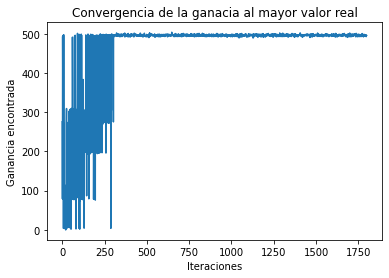

In [ ]:

a,b = main(1800,0.0001)
print (a)
fig, ax = plt.subplots()
ax.set_xlabel('Iteraciones')
ax.set_ylabel('Ganancia encontrada')
ax.set_title('Convergencia de la ganacia al mayor valor real')
plt.plot(b)

[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]
[ 0.  2.  4. 11. 12.]


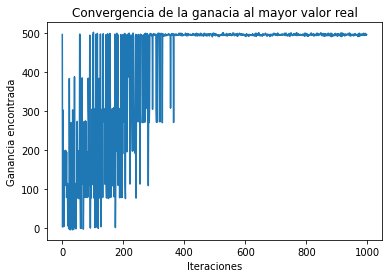

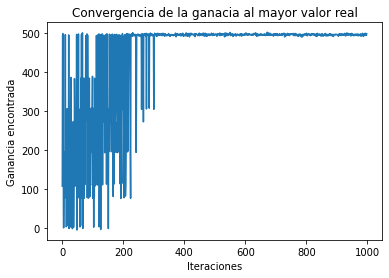

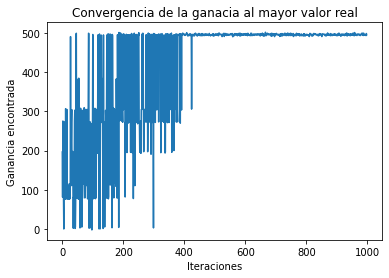

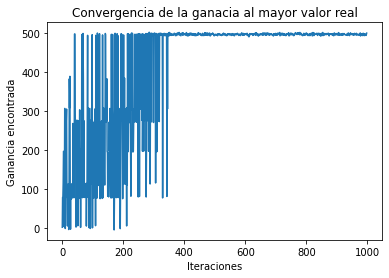

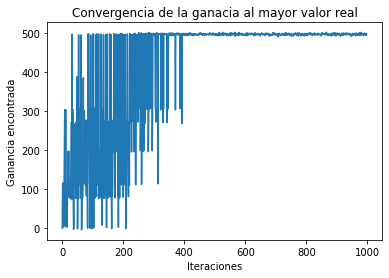

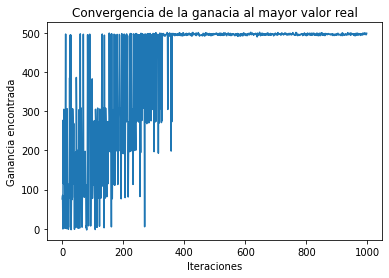

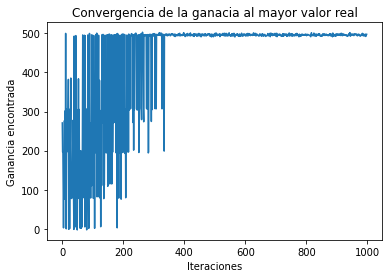

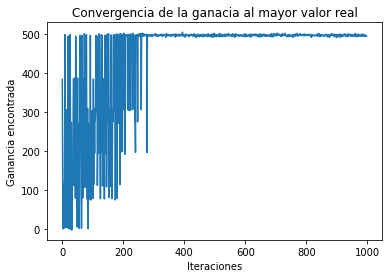

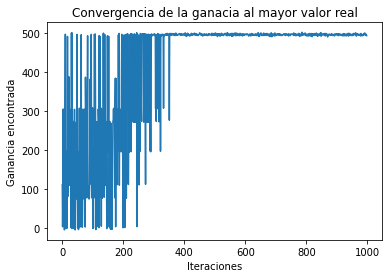

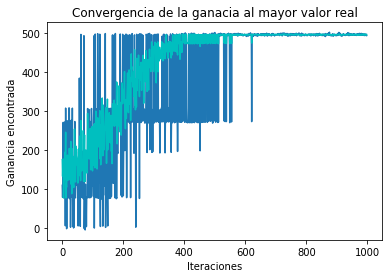

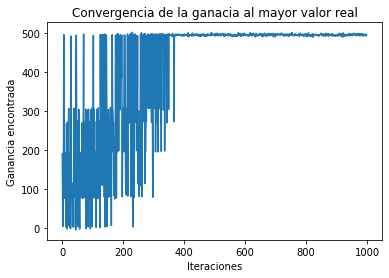

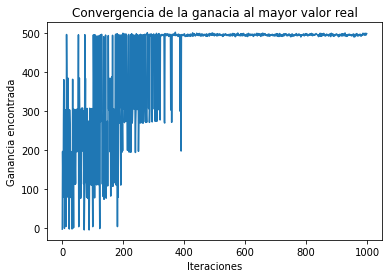

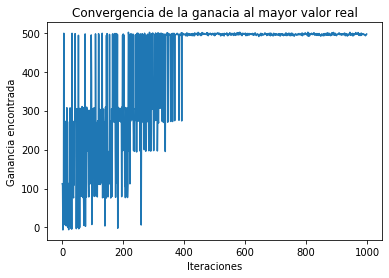

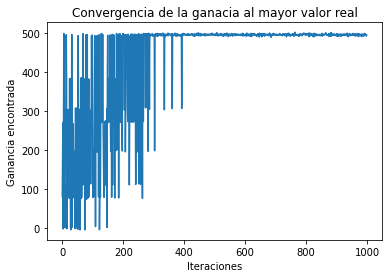

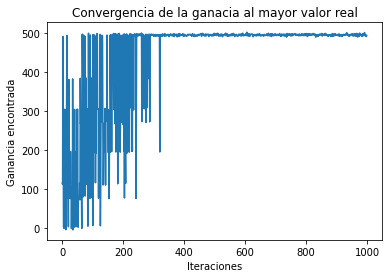

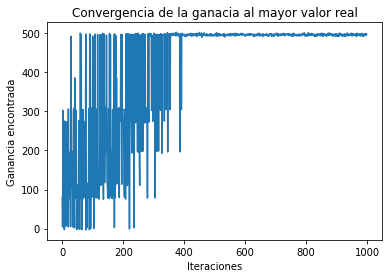

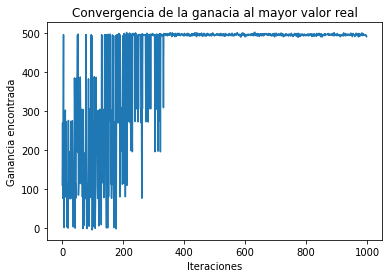

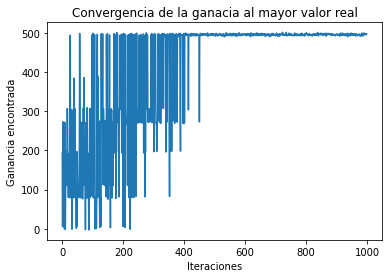

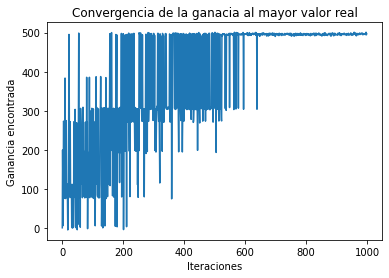

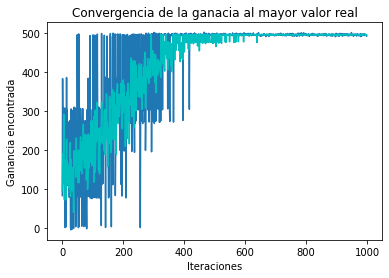

In [ ]:
import matplotlib.pyplot as plt
#print (main(100))

for t in [999,1000]:
    for x in range(80, 81, 1):
         acum = 0
         for i in range (10):
           a,b = main(t,float(x/1000000))
           print (a)
           fig, ax = plt.subplots()
           ax.set_xlabel('Iteraciones')
           ax.set_ylabel('Ganancia encontrada')
           ax.set_title('Convergencia de la ganacia al mayor valor real')
           plt.plot(b)
           acum += b
         g = acum/(i+1)
         #print(f'Con {t} iteraciones y deltha en {x/100000} el promedio de ganancia en {i} ejcuciones es {acum/(i+1)}')
         plt.plot(g, 'c')